### Porto Seguro’s Safe Driver Prediction - проект по Методам оптимизации, 3 курс ИТМО

Условие задачи с [Kaggle](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction): (state of the problem)

>Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

>Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

>In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

### Data Description

>In this competition, you will predict the probability that an auto insurance policy holder files a claim.

>In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., *ind*, *reg*, *car*, *calc*). In addition, feature names include the postfix *bin* to indicate binary features and *cat* to indicate categorical features. Features without these designations are either continuous or ordinal. Values of **-1** indicate that the feature was missing from the observation. The *target* columns signifies whether or not a claim was filed for that policy holder.


### Описание проекта (Project description)

* 1. Пропуски данных (Finding the Missing Data)
* 2. Ненужные классификаторы (Drop fields & Replace Missing Data)
* 3. Подготовка данных (Data Preparation)
* 4. Выбор признаков классификаторов (Random Forest Classifier)
* 5. Обучение (Logistic Regression)
* 6. Выводы (Predict & Output)
* 7. Kaggle Score

In [44]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.preprocessing import StandardScaler
#Standard Scaler - normalizing/standardizing data 
#from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
#Random Forest Classifier consists of a large number of individual decision trees 
#that operate together
#Each individual tree in the random forest spits out a class prediction 
#and the class with the most votes becomes our model’s prediction

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns
#это более высокоуровневое API на базе библиотеки matplotlib. 
#Seaborn содержит более адекватные дефолтные настройки оформления графиков. 
#Если просто добавить в код import seaborn, то картинки станут гораздо симпатичнее. 
#Также в библиотеке есть достаточно сложные типы визуализации, которые в matplotlib потребовали бы большого количество кода.
#Source: https://nagornyy.me/courses/data-science/intro-to-seaborn

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#read data
train = pd.read_csv("/Users/atereh/Downloads/train.csv") 
test = pd.read_csv("/Users/atereh/Downloads/test.csv")
print(train.shape)
print(test.shape)
train.head()


(595212, 59)
(892816, 58)


id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1           1           9               0   
2           4           2           7           7               0   
3           2           2           4           9               0   
4           3           1           1           3               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               1               1               0               1   
2               1               1               0               1   
3               0               0               0               0   
4               0               0               1               1   

   ps_calc_20_bin  
0               1  
1               0  
2               0  
3               0  
4               0  

[5 rows x 59 columns]

Датасет *test* имеет на 1 колонку меньше - **target**

### Пропуски данных (Finding the Missing Data)

Из описания данных поля **-1** - данные, которых у нас нет. Нам необходимо сначала проверить такие данные в train. 


In [12]:
#выбираем топ 5 классификаторов с пропусками данных и считаем сколько всего записей пропущено

train = train.replace(-1, np.nan)
train_missing = train.isnull().sum().sort_values(ascending=False)
train_missing = pd.DataFrame(train_missing).reset_index()
train_missing.columns = ['Field', 'Number of Missing Data']
train_missing.head()

Field  Number of Missing Data
0  ps_car_03_cat                  411231
1  ps_car_05_cat                  266551
2      ps_reg_03                  107772
3      ps_car_14                   42620
4  ps_car_07_cat                   11489

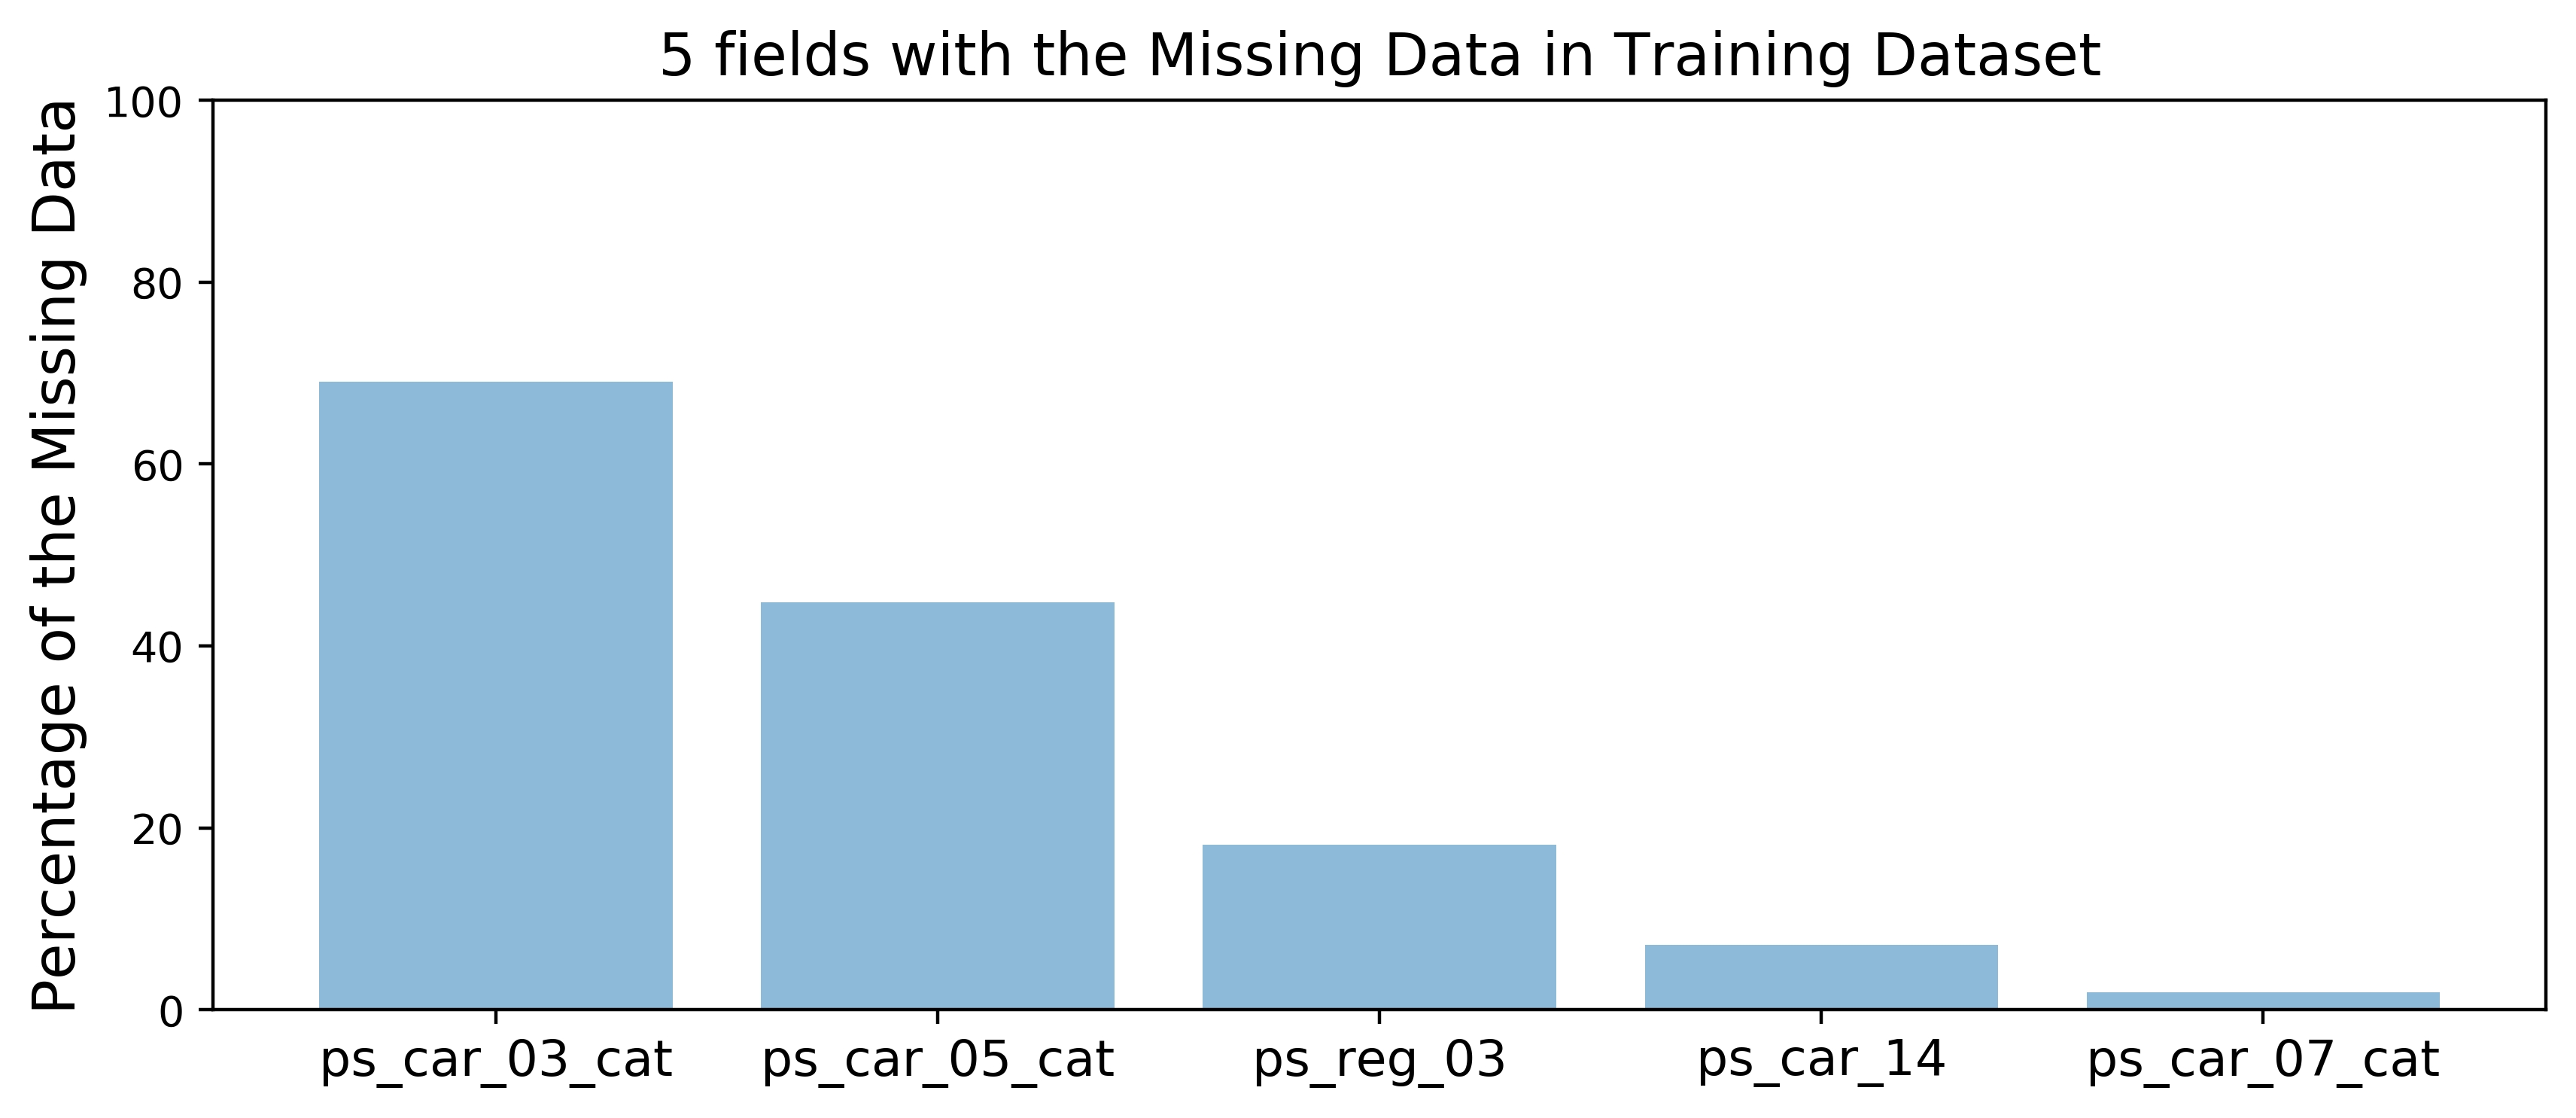

In [13]:
#Визуализация пропущенных данных в диаграмме в процентах

train_missingpercent = 100 * (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

plt.figure(figsize = (10, 4), dpi = 400)
plt.bar(np.arange(5), train_missingpercent[:5], align='center', alpha=0.5)
plt.xticks(np.arange(5), train_missingpercent.index[:5], fontsize=12)
plt.ylim(0, 100)
plt.ylabel('Percentage of the Missing Data', fontsize = 14)
plt.title('5 fields with the Missing Data in Training Dataset', fontsize = 14) 
plt.show()

### Ненужные поля классификаторы (Drop fields & Replace Missing Data)

* Поля **'ps_car_03_cat'** и **'ps_car_05_cat'** имеют больше 40% пропусков, так что мы можем просто убрать их.
* Дальше проанализируем корреляцию всех остальных полей и также выкинем ненужные (calc)
* Заменим отсутствующие данные в оставшихся полях

In [14]:
#drop-аем поля'ps_car_03_cat','ps_car_05_cat'

train = train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)
test = test.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)

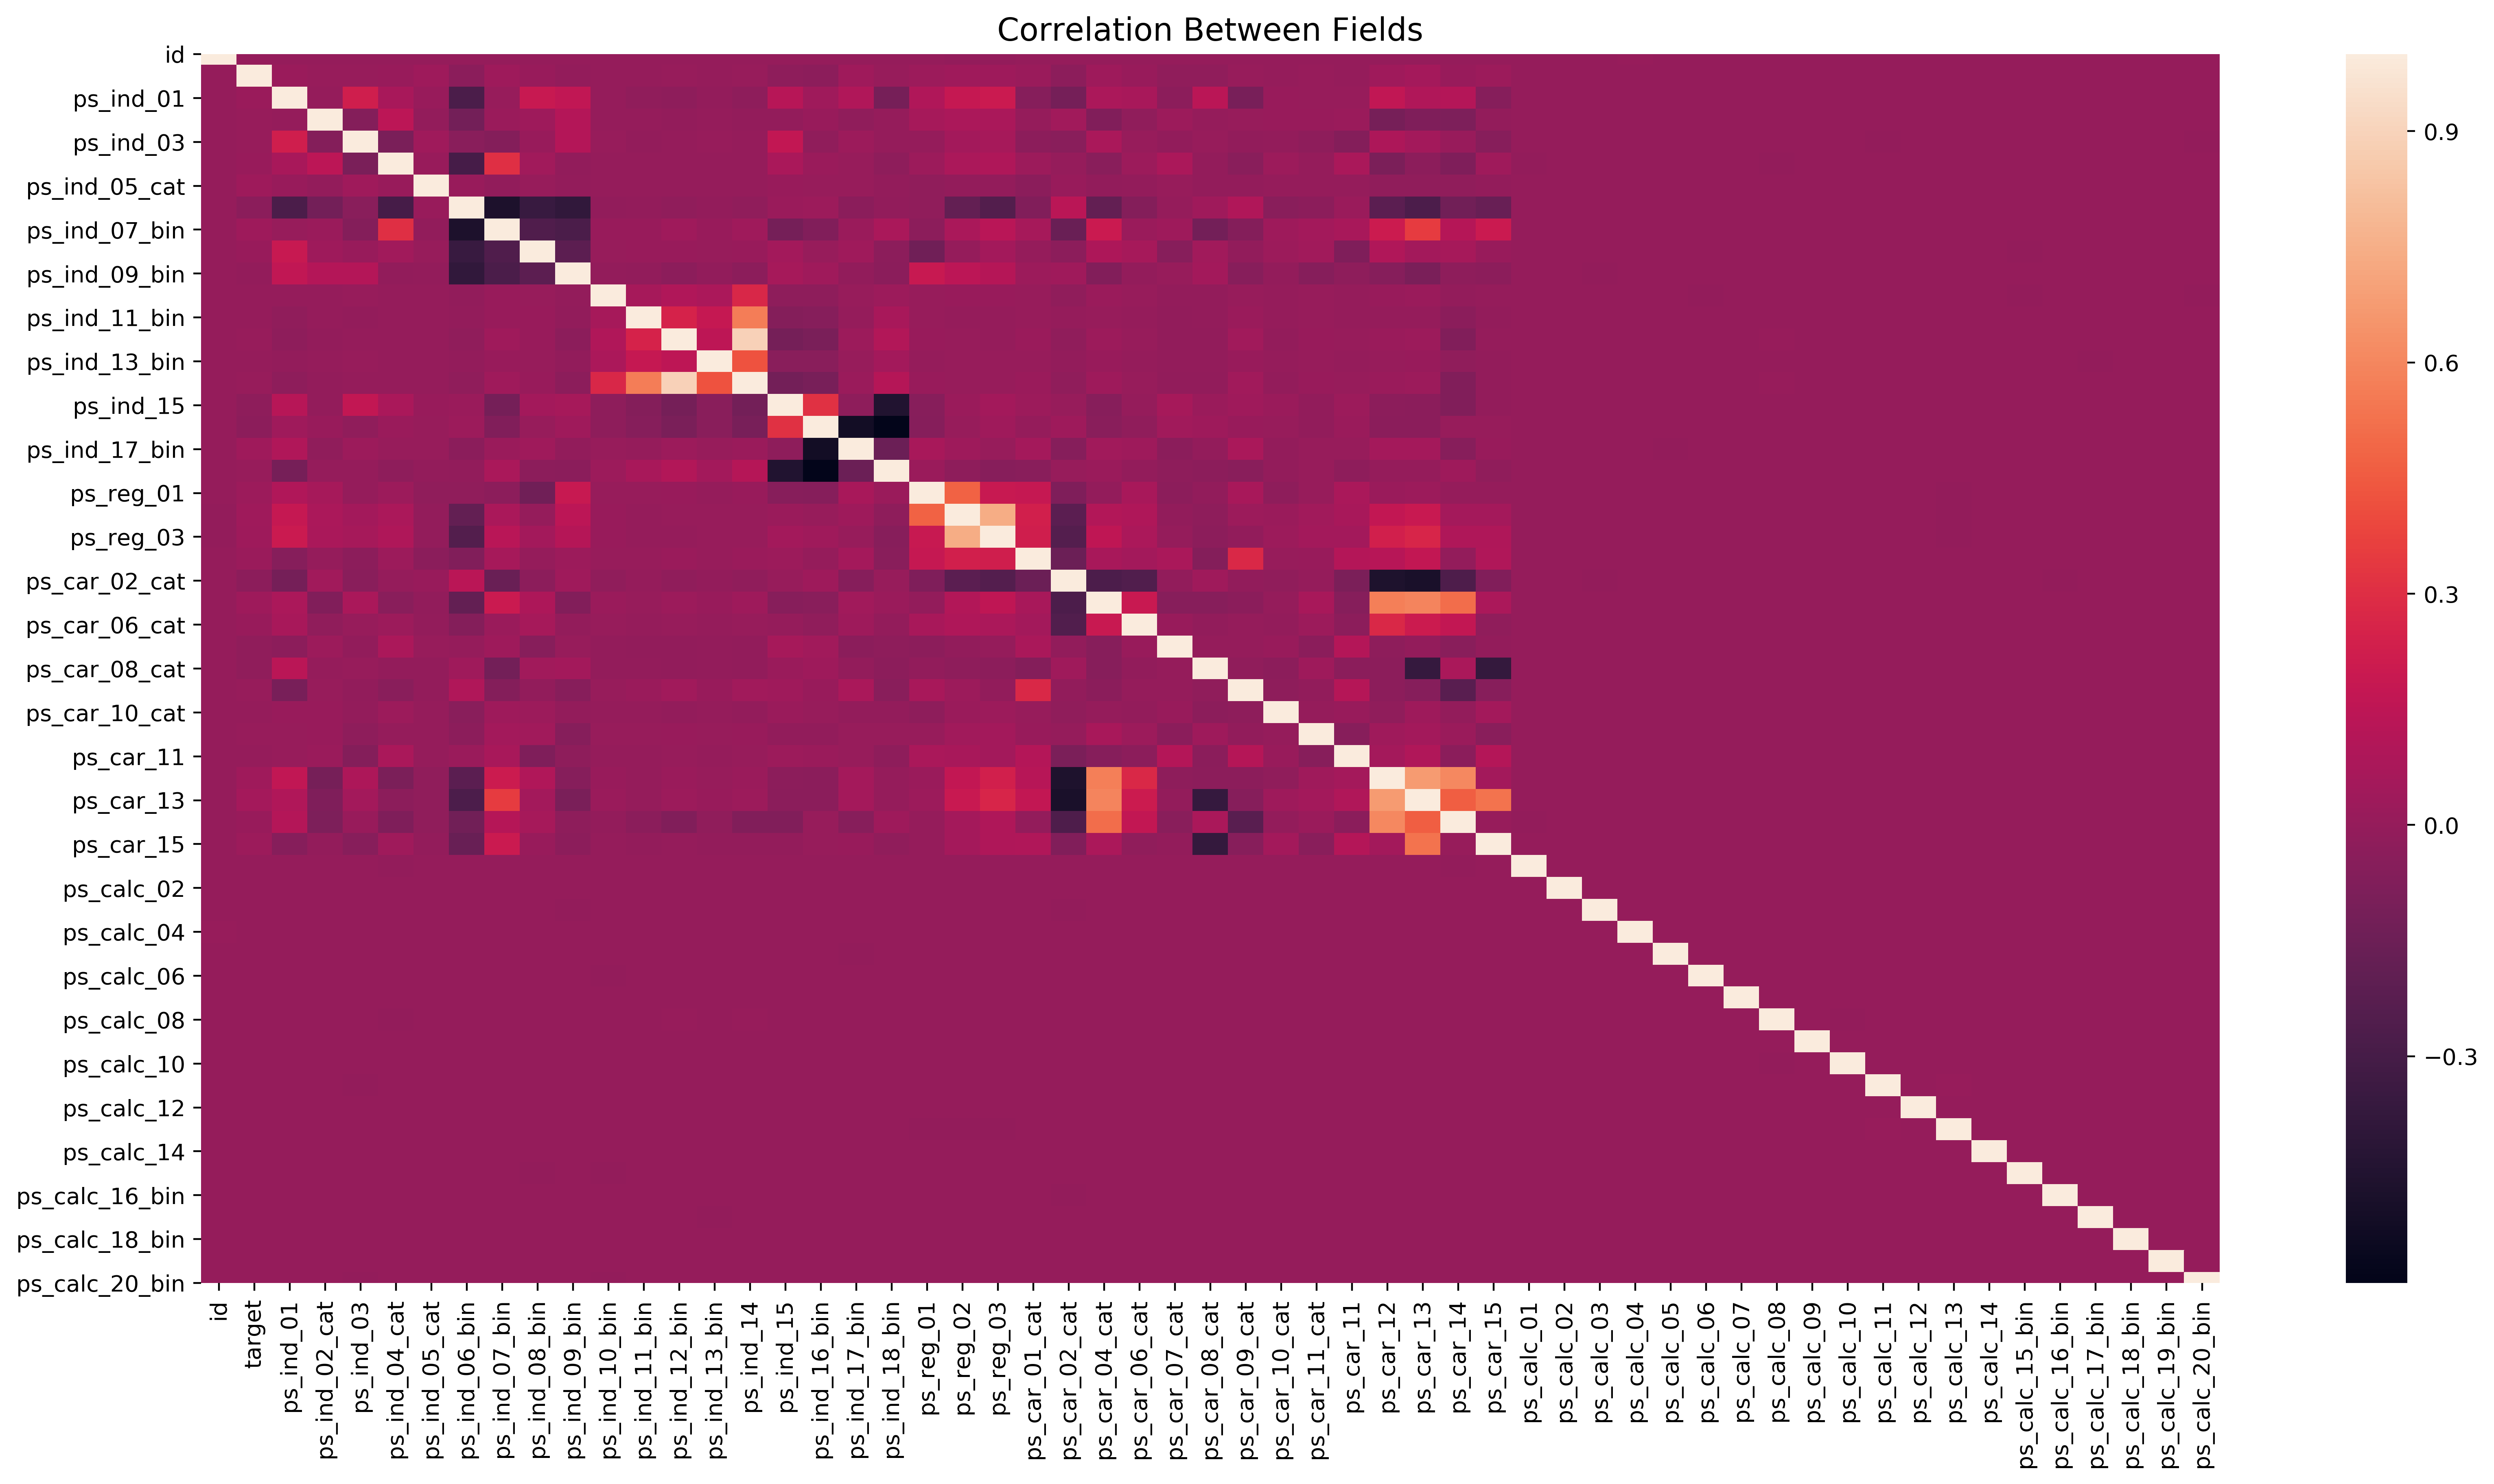

In [15]:
# визуализируем корреляцию оставшихся полей

corr = train.corr()

plt.figure(figsize = (20,10), dpi= 400)
sns.heatmap(corr)
plt.title("Correlation Between Fields", fontsize = 14)
plt.xticks(rotation = 'vertical')

plt.show()

Замечаем, что поля, помеченные **_calc_** в имени мало коррелируют со всеми остальными в датасете train. Чтобы уменшить размерность нашей функции - выбросим эти поля тоже

In [17]:
#drop fields '_calc_' 
feature_calc = list(train.columns[train.columns.str.contains('_calc_')])

train = train.drop(feature_calc, axis = 1)
test = test.drop(feature_calc, axis = 1)

print (train.shape)
print (test.shape)

(595212, 37)
(892816, 36)


Построим корреляцию для обновленного датасета:

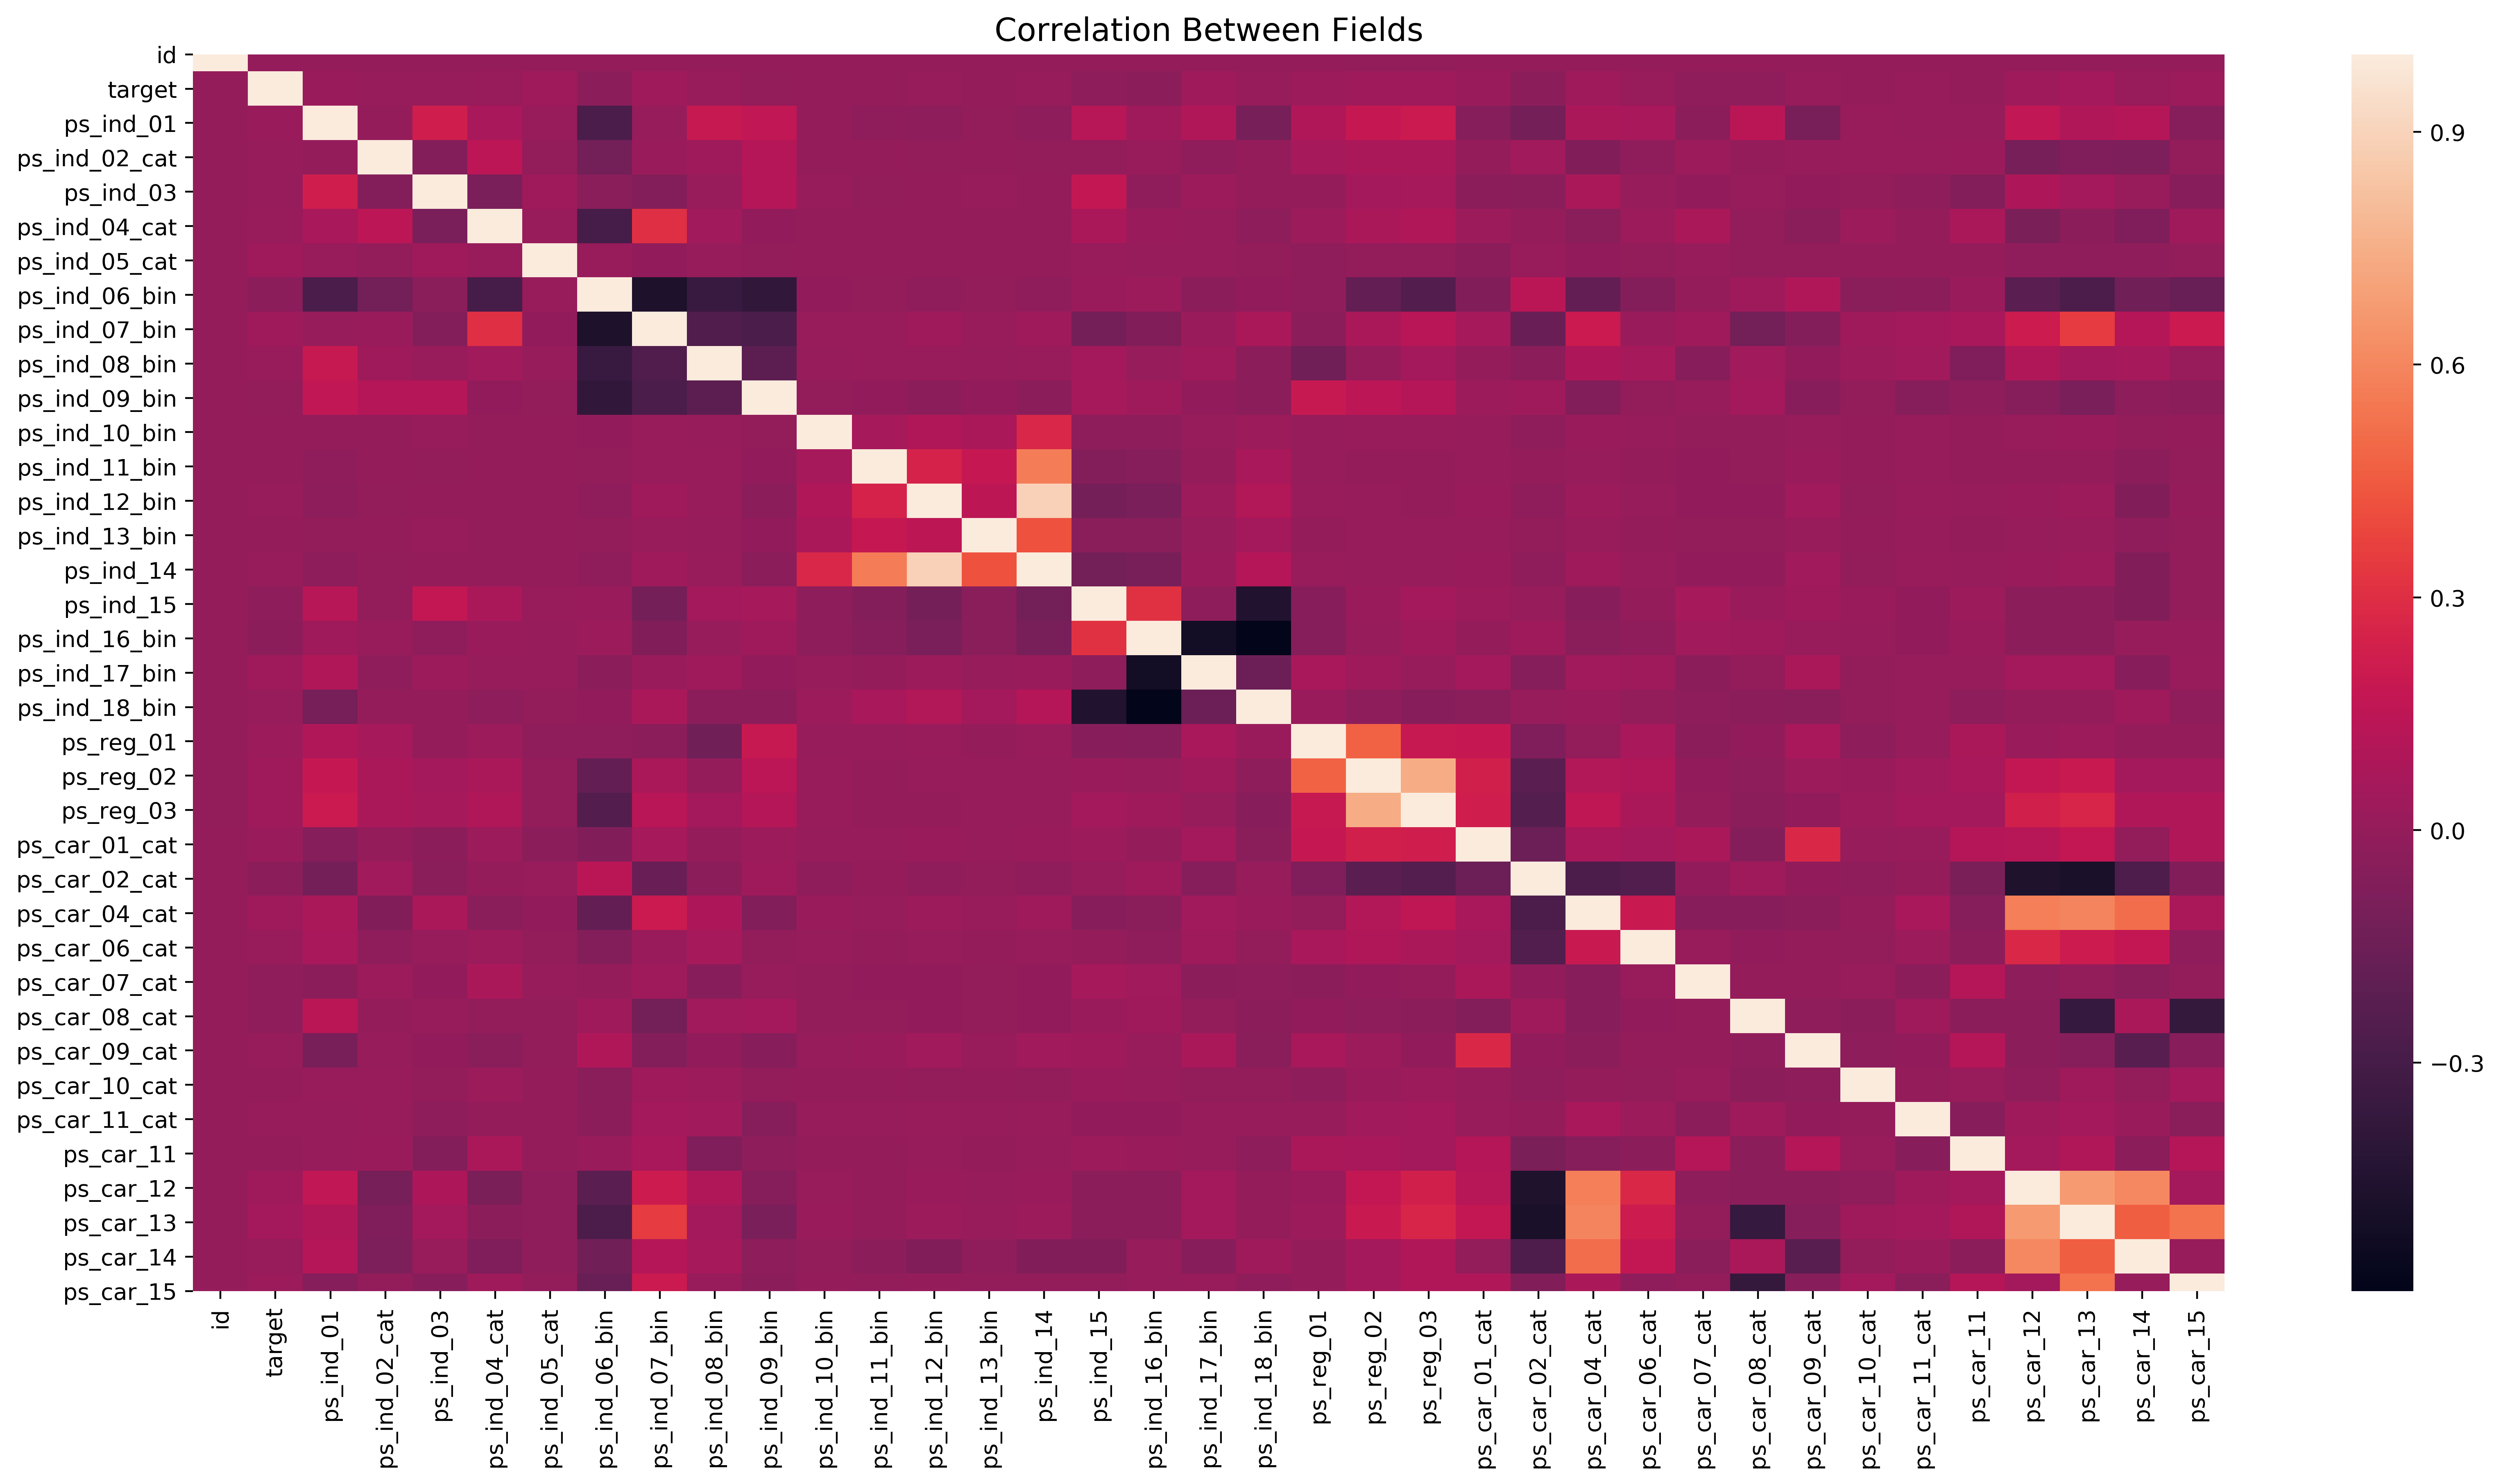

In [18]:
corr = train.corr()

plt.figure(figsize = (20,10), dpi= 400)
sns.heatmap(corr)
plt.title("Correlation Between Fields", fontsize = 14)
plt.xticks(rotation = 'vertical')

plt.show()

Далее производим замену данных в оставшихся признаках:
* Для бинарных признаков классификаторов (bin) и категориальных признаков классификаторов (cat), заменим отсутствующие данные модой по признаку
* Для остальных признаков, заменим отсутствующие данные средним значением по признаку классификатору

In [20]:
# заменяем отсутсвующие данные в полях
feature_bin = [f for f in train.columns if f.endswith('bin')] 
feature_cat = [f for f in train.columns if f.endswith('cat')] 
feature_els = [f for f in train.columns if (f not in feature_bin) & (f not in feature_cat) & (f not in ['id', 'target'])]

for f in (feature_bin + feature_cat):
    train[f].fillna(value=train[f].mode()[0], inplace=True)
    test[f].fillna(value=test[f].mode()[0], inplace=True)
    
for f in feature_els:
    train[f].fillna(value=train[f].mean(), inplace=True)
    test[f].fillna(value=test[f].mean(), inplace=True)

Теперь посмотрим на data distribution этих признаков:

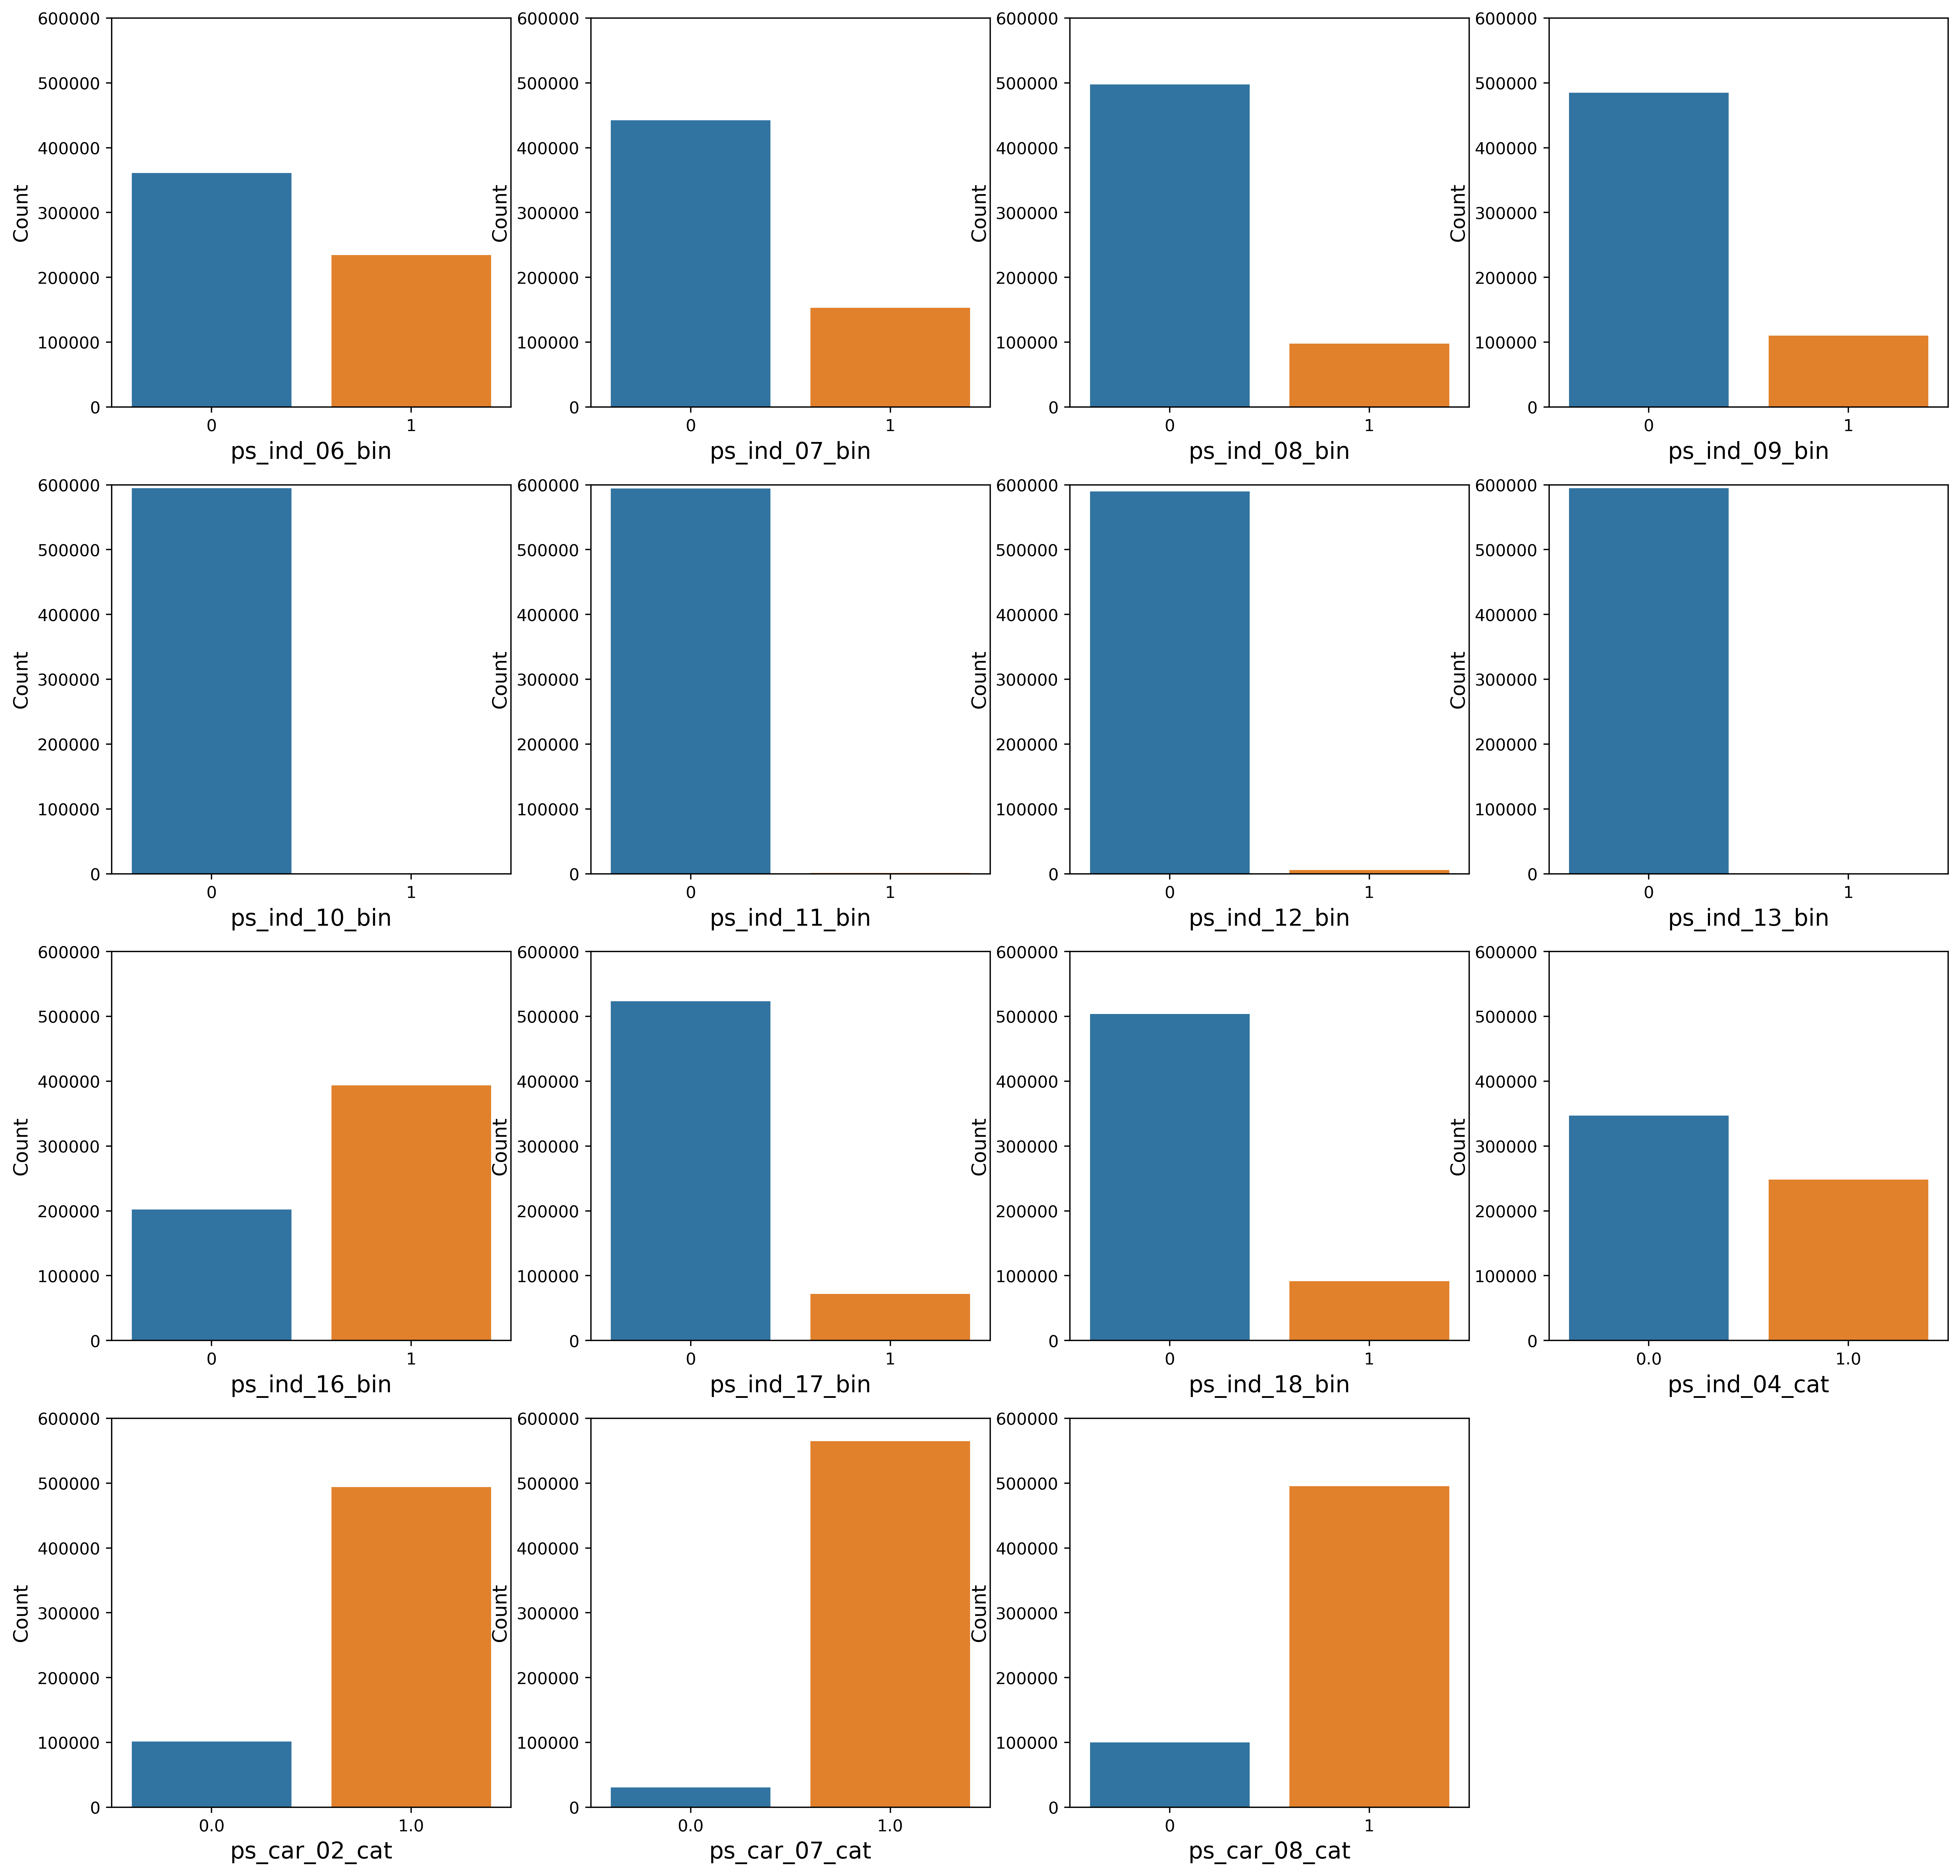

In [23]:
#визуализация bin признаков классификаторов и категориальных полей классификаторов 
plt.figure(figsize=(20, 20), dpi = 400)
count = 0

for f in (feature_bin + feature_cat):
    if  train[f].nunique() <= 2:
        ax = plt.subplot(4, 4, count+1)
        sns.countplot(train[f])
        plt.xlabel(f, fontsize = 14)
        plt.ylabel("Count", fontsize = 12)
        plt.ylim(0, 600000)
        count += 1
        

plt.show()

### Подготовка данных (Data Preparation)

* Перед тем, как применить на данные алгоритм машинного обучения, нужно нормализовать все признаки классификаторы
* Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим метод One-Hot Encoding.


In [22]:
# нормализация некатегориальных полей 
feature_non_cat = [f for f in train.columns if (f.endswith('cat') != True) & (f not in ['id', 'target'])]
scaler = StandardScaler()

X_train = train.drop(['target', 'id'], axis=1)
y_train = train['target']
X_valid = test.drop('id', axis=1)

X_train.loc[:, feature_non_cat] = scaler.fit_transform(X_train[feature_non_cat])
X_valid.loc[:, feature_non_cat] = scaler.transform(X_valid[feature_non_cat])

Далее сконвертируем категориальные признаки с помощью One-hot encoding. Предположим, что некоторый признак может принимать 10 разных значений. В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1.

Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.

Признак **'ps_car_11_cat'** принимает 104 уникальных значения. С этой проблемой в дальнейшем будет бороться Random Forest.

In [16]:
print train['ps_car_11_cat'].unique()

[ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


Так как признак **'ps_car_11_cat'** и другие имеют подобное количество значений, следующий шаг разбияния признаков с помощью One-hot encoding:

In [25]:
# конвертация категориальных признаков в one-hot encoding
train_num = train.shape[0]

dataset = pd.concat([X_train, X_valid], axis=0)   
dataset = pd.get_dummies(columns=feature_cat, data=dataset)

X_train = dataset[:train_num]
X_valid = dataset[train_num:]
print (X_train.shape)
print (X_valid.shape)

(595212, 201)
(892816, 201)


### Выбор признаков классификаторов (Random Forest Classifier)

Теперь у нас есть датафрейм с 201 колонкой. Используем Random Forest Classidier для выбора 20-ти наиболее важных признаков по которым будем строить обучение. 

In [45]:
# разобьем показатели на 2 подвыборки(обучающую и тестовую) 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_train, y_train, train_size = 0.7)

В качестве параметров train_test_split передается:
* Массив параметров
* Массив значений показателей
* Соотношение в котором будет разбита обучающая выборка (в нашем случае для тестового набора будет выделена 30 % часть данных исходной обучающей выборки)

На выходе функция выдает 4 массива:
* Новый обучающий массив параметров
* Тестовый массив параметров
* Новый массив показателей
* Тестовый массив показателей

In [27]:
# тренируем модель на 40 деревьях, 4 параллельных процессах, и 10 минимальных сэмплов 
num_trees = 40
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=4, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=X_train, y=y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 40building tree 2 of 40
building tree 3 of 40
building tree 4 of 40

building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.5s


building tree 40 of 40


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   39.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=4,
                       oob_score=True, random_state=None, verbose=2,
                       warm_start=False)

In [55]:
# генерируем предсказания на тестовом датасете (который мы отбили у train ранее)
rf_predictions = rf.predict_proba(X_test)[:, 1]

# AUC score (вероятностное распределение)
print (roc_auc_score(y_test, rf_predictions))

# accuracy score (предсказание по классам) - бесполезная метрика :)
rf_predictions_class = rf.predict(X_test)
print (accuracy_score(y_test, rf_predictions_class, normalize=True))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.8s finished


0.9998703195591474


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.9634611867971107


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.5s finished


In [48]:
# выберем 20 самых важных признаков
# и посчитаем их важность
feature_names = list(X_test.columns.values)
feature_importances = list(rf.feature_importances_)
feature_list = []

for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))
    
df_feature_select20 = pd.DataFrame(sorted(feature_list, reverse=True, key=lambda x: x[1])[:20])
df_feature_select20.columns = ['field', 'importance_index']
print (df_feature_select20)

                 field  importance_index
0            ps_car_13          0.101594
1            ps_reg_03          0.095132
2            ps_car_14          0.056554
3            ps_ind_03          0.053226
4            ps_ind_15          0.051418
5            ps_reg_02          0.049340
6            ps_reg_01          0.038452
7            ps_car_15          0.038088
8            ps_ind_01          0.037313
9            ps_car_12          0.026891
10           ps_car_11          0.012690
11   ps_ind_02_cat_1.0          0.008882
12  ps_car_01_cat_11.0          0.008864
13   ps_car_09_cat_2.0          0.008627
14       ps_ind_16_bin          0.008145
15   ps_ind_04_cat_0.0          0.008082
16   ps_ind_04_cat_1.0          0.007991
17   ps_ind_02_cat_2.0          0.007714
18   ps_car_09_cat_0.0          0.007671
19   ps_car_01_cat_7.0          0.007237


In [50]:
# режем датасеты, чтобы они содержали информацию только об этих 20 признаках
X_train_select20 = X_train[df_feature_select20['field']]
X_valid_select20 = X_valid[df_feature_select20['field']]
X_test_select20 = X_test[df_feature_select20['field']]

### Тренировка модели (Logistic Regression)

Начнем тренировку модели на данных, которые мы выделили. Используем логистическую регрессию

In [56]:
lr = LogisticRegression()
lr.fit(X_train, y_train)


/Users/atereh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Выводы (Predict & Output)

Применяем модель логистической регрессии на датасет, записываем предсказание рисков в (**_target_** value) result.csv файл.

In [54]:
# применеям модель на тестовый датасет
id = test.id
result = lr.predict_proba(X_valid)

output = pd.DataFrame( { 'id': id , 'target': result[:,1]} )
output = output[['id', 'target']]

output.to_csv("/Users/atereh/Downloads/rsult.csv", index = False)
output.head(10)

id    target
0   0  0.030330
1   1  0.031750
2   2  0.023103
3   3  0.019123
4   4  0.033465
5   5  0.033479
6   6  0.023347
7   8  0.019712
8  10  0.061216
9  11  0.044289

### Submit to Kaggle Competition
Current competition normalized Gini index: **0.23114** 

Place ~ 4400 out of 5200